<a href="https://colab.research.google.com/github/dimasaryamurdiyan/apriory-algorithm-in-transactional-data/blob/main/apriory_coffee_shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install numpy
!pip install apyori


  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=9d3a789a1df624c50c50fa2a6f076877b71e8c5908ff87dab6ec9d0644f87555
  Stored in directory: /root/.cache/pip/wheels/77/3d/a6/d317a6fb32be58a602b1e8c6b5d6f31f79322da554cad2a5ea
Successfully built apyori


# Import library needed

In [37]:
import pandas as pd
import numpy as np
from apyori import apriori

In [38]:
# mounted drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dataset - Data Selection

In [39]:
# load excel data from gdrive and convert into DataFrame
df = pd.read_excel('/content/drive/My Drive/skripsi/dataset_transaksi_sentani_kopi.xlsx') # Added '/content/' to the beginning of the path
df.head()

,order no,items,order time,order source,served by,total qty,currency,subtotal,net amount,discount,total amount,nett profit,payment mode,payment amount,payment date
0,B1AF24070100000001,"Kopi Susu, Kopi Susu",2024-07-01 16:18:36,POINT OF SALE,Ressy,2,IDR,30000,30000,9000,21000,21000,CASH,21000,2024-07-01 16:18:36
1,B1AF24070100000003,Es Kopi Susu Gula Aren,2024-07-01 18:06:09,POINT OF SALE,Rahmat,1,IDR,18000,18000,0,18000,18000,CASH,18000,2024-07-01 18:06:09
2,B1AF24070100000004,Taro ice,2024-07-01 18:15:45,POINT OF SALE,Rahmat,1,IDR,15000,15000,0,15000,15000,CASH,15000,2024-07-01 18:15:45
3,B1AF24070100000005,Es Kopi Susu Classic,2024-07-01 19:33:21,POINT OF SALE,Rahmat,1,IDR,16000,16000,0,16000,16000,CASH,16000,2024-07-01 19:33:21
4,B1AF24070100000006,Tipoloco,2024-07-01 20:33:56,POINT OF SALE,Rahmat,1,IDR,15000,15000,0,15000,15000,CASH,15000,2024-07-01 20:33:56


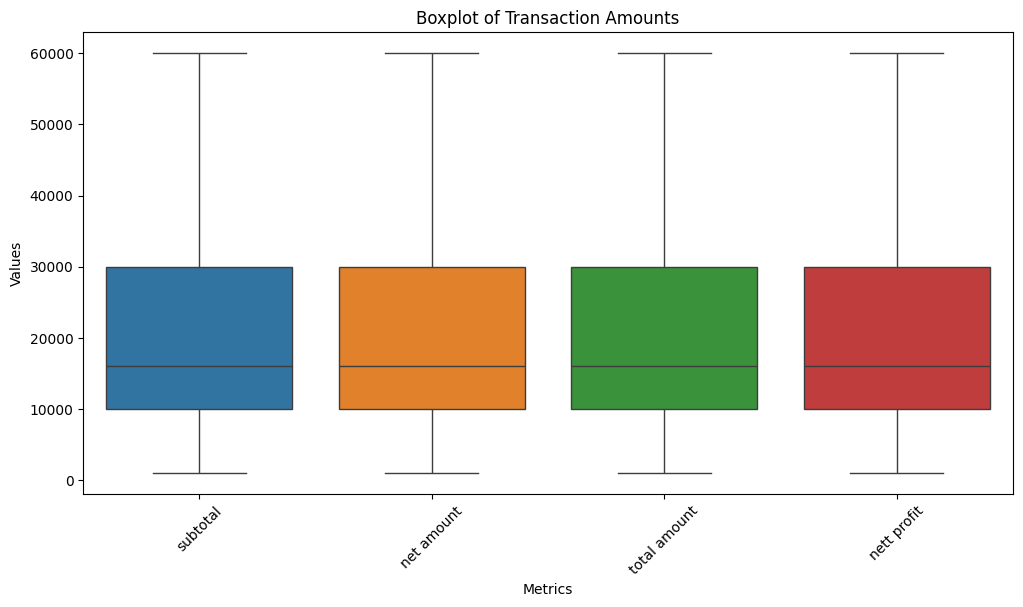

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Selecting relevant numerical columns for the boxplot
numerical_columns = ["subtotal", "net amount", "total amount", "nett profit"]

# Calculate the Interquartile Range (IQR) to detect outliers
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for acceptable data range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers instead of removing them
df_capped = df.copy()
for col in numerical_columns:
    df_capped[col] = np.where(
        df_capped[col] > upper_bound[col], upper_bound[col],
        np.where(df_capped[col] < lower_bound[col], lower_bound[col], df_capped[col])
    )

# Creating a boxplot after capping extreme values
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_capped[numerical_columns])

# Customizing the plot
plt.xticks(rotation=45)
plt.title("Boxplot of Transaction Amounts")
plt.ylabel("Values")
plt.xlabel("Metrics")

# Show the plot
plt.show()

# Data Pre-Procesing / Data Cleansing

Drop all column except `order no` and `items`

In [40]:
import re

# clean text before processing
def clean_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = re.sub(r'\.', ',', text)  # Replace period with comma
        text = re.sub(r', ', ',', text)  # Replace ', ' with ','
        text = re.sub(r' ,', ',', text)  # Replace ', ' with ','
        return text.lower()
    else:
        return ''

df['items'] = df['items'].apply(clean_text)

df_with_date = df[['order no','items', 'order time']]

df_data = df

# Select only the `order no` and `items` columns from the DataFrame
df = df[['order no','items']]
df.head()

,order no,items
0,B1AF24070100000001,"kopi susu,kopi susu"
1,B1AF24070100000003,es kopi susu gula aren
2,B1AF24070100000004,taro ice
3,B1AF24070100000005,es kopi susu classic
4,B1AF24070100000006,tipoloco


In [41]:
# drop row that contains NaN(null) value on `items` column
df = df.dropna(subset=['items'])
df.head()

,order no,items
0,B1AF24070100000001,"kopi susu,kopi susu"
1,B1AF24070100000003,es kopi susu gula aren
2,B1AF24070100000004,taro ice
3,B1AF24070100000005,es kopi susu classic
4,B1AF24070100000006,tipoloco


# Data Transformation

All given data will transform into single items, and then convert the items into columns and the order no into rows

In [42]:
from collections import Counter
# Tokenize
"""Transforms the dataframe to have individual items per row.

  Args:
    df: The input dataframe with 'order no' and 'items' columns.

  Returns:
    A new dataframe with individual items per row.
"""
def transform_data(df):
    new_rows = []
    for index, row in df.iterrows():
        order_no = row['order no']
        items = row['items'].split(',')  # Split items by ','
        item_counts = Counter(items)  # Count occurrences of each item

        for item, quantity in item_counts.items():
            new_rows.append({'order no': order_no, 'item': item, 'quantity': quantity})


    return pd.DataFrame(new_rows)

transformed_df = transform_data(df)
transformed_df

,order no,item,quantity
0,B1AF24070100000001,kopi susu,2
1,B1AF24070100000003,es kopi susu gula aren,1
2,B1AF24070100000004,taro ice,1
3,B1AF24070100000005,es kopi susu classic,1
4,B1AF24070100000006,tipoloco,1
...,...,...,...
5338,B1AF24123100003215,vietnam drip,2
5339,B1AF24123100003216,taro ice,1
5340,B1AF24123100003217,kopi hitam,1
5341,B1AF24123100003217,kopi susu,1


In [43]:
# create matrix
basket = transformed_df.groupby(['order no', 'item'])['quantity'].count().unstack().reset_index().fillna(0).set_index('order no')
basket.head()

item,,kentang goreng,kopi susu,air es,air mineral,americano,b1af24111300002472,blend 70:30 (250 gr),cappuccino,cappucino,...,telur,tempura ikan,tipoloco,tropical fiz,v60 mangg,v60 mangga,v60mangga,vietnam drip,vietnam drip,virgin
order no,,,,,,,,,,,,,,,,,,,,,
8B7824081300000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8B7824081300000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8B7824081300000007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8B7824081300000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8B7824081300000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# encoding process -> convert data into numeric
def encode(item_freq):
    if item_freq <= 0:
      return 0
    if item_freq >= 1:
      return 1

basket_input = basket.applymap(encode)
basket_input.head()

<ipython-input-44-ec4d55f309e4>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_input = basket.applymap(encode)


item,,kentang goreng,kopi susu,air es,air mineral,americano,b1af24111300002472,blend 70:30 (250 gr),cappuccino,cappucino,...,telur,tempura ikan,tipoloco,tropical fiz,v60 mangg,v60 mangga,v60mangga,vietnam drip,vietnam drip,virgin
order no,,,,,,,,,,,,,,,,,,,,,
8B7824081300000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8B7824081300000006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8B7824081300000007,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8B7824081300000008,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8B7824081300000009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Filter

In [45]:
# filter rows that bought more than 1 items
basket_filter = basket_input[(basket_input > 0).sum(axis=1) >= 2]
basket_filter

item,,kentang goreng,kopi susu,air es,air mineral,americano,b1af24111300002472,blend 70:30 (250 gr),cappuccino,cappucino,...,telur,tempura ikan,tipoloco,tropical fiz,v60 mangg,v60 mangga,v60mangga,vietnam drip,vietnam drip,virgin
order no,,,,,,,,,,,,,,,,,,,,,
8B7824081300000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8B7824081300000007,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8B7824081300000008,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8B7824081300000031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8B7824081300000039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B1AF24123100003209,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
B1AF24123100003210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B1AF24123100003213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Descriptive Analysis

Top 10 Items Bought

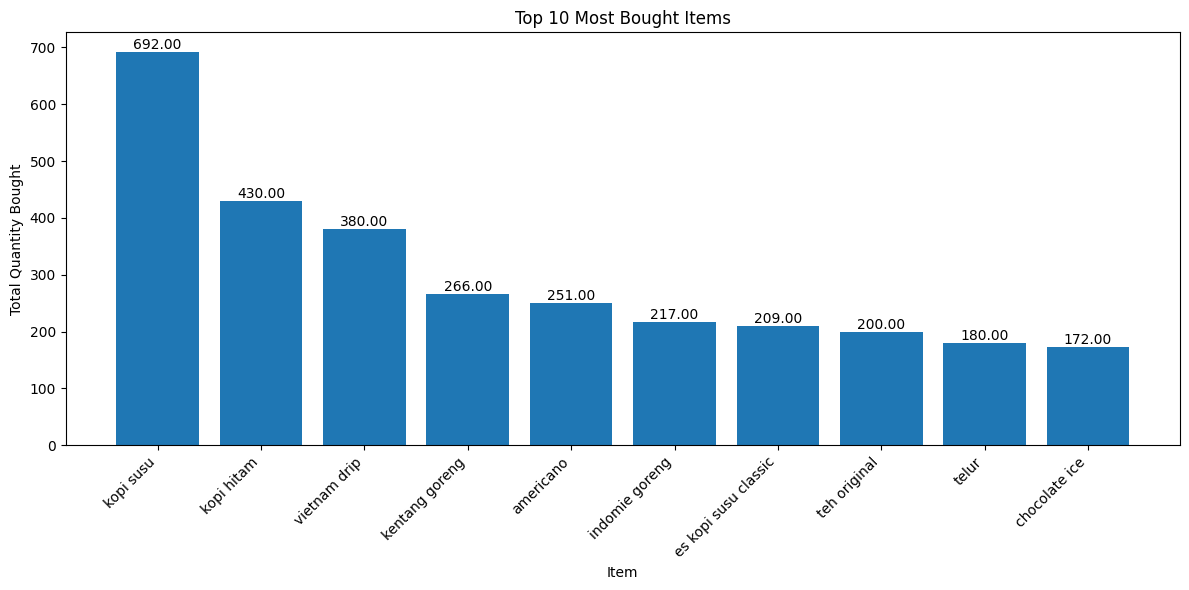

In [13]:
import matplotlib.pyplot as plt

# Group by 'item' and sum 'quantity' to get total purchases for each item
item_counts = transformed_df.groupby('item')['quantity'].sum().sort_values(ascending=False)

# Select the top 10 items
top_10_items = item_counts.head(10)

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
bars = plt.bar(top_10_items.index, top_10_items.values)  # Store the bar objects


plt.xlabel("Item")
plt.ylabel("Total Quantity Bought")
plt.title("Top 10 Most Bought Items")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# Add amount labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
             ha='center', va='bottom')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

Daily Transactions

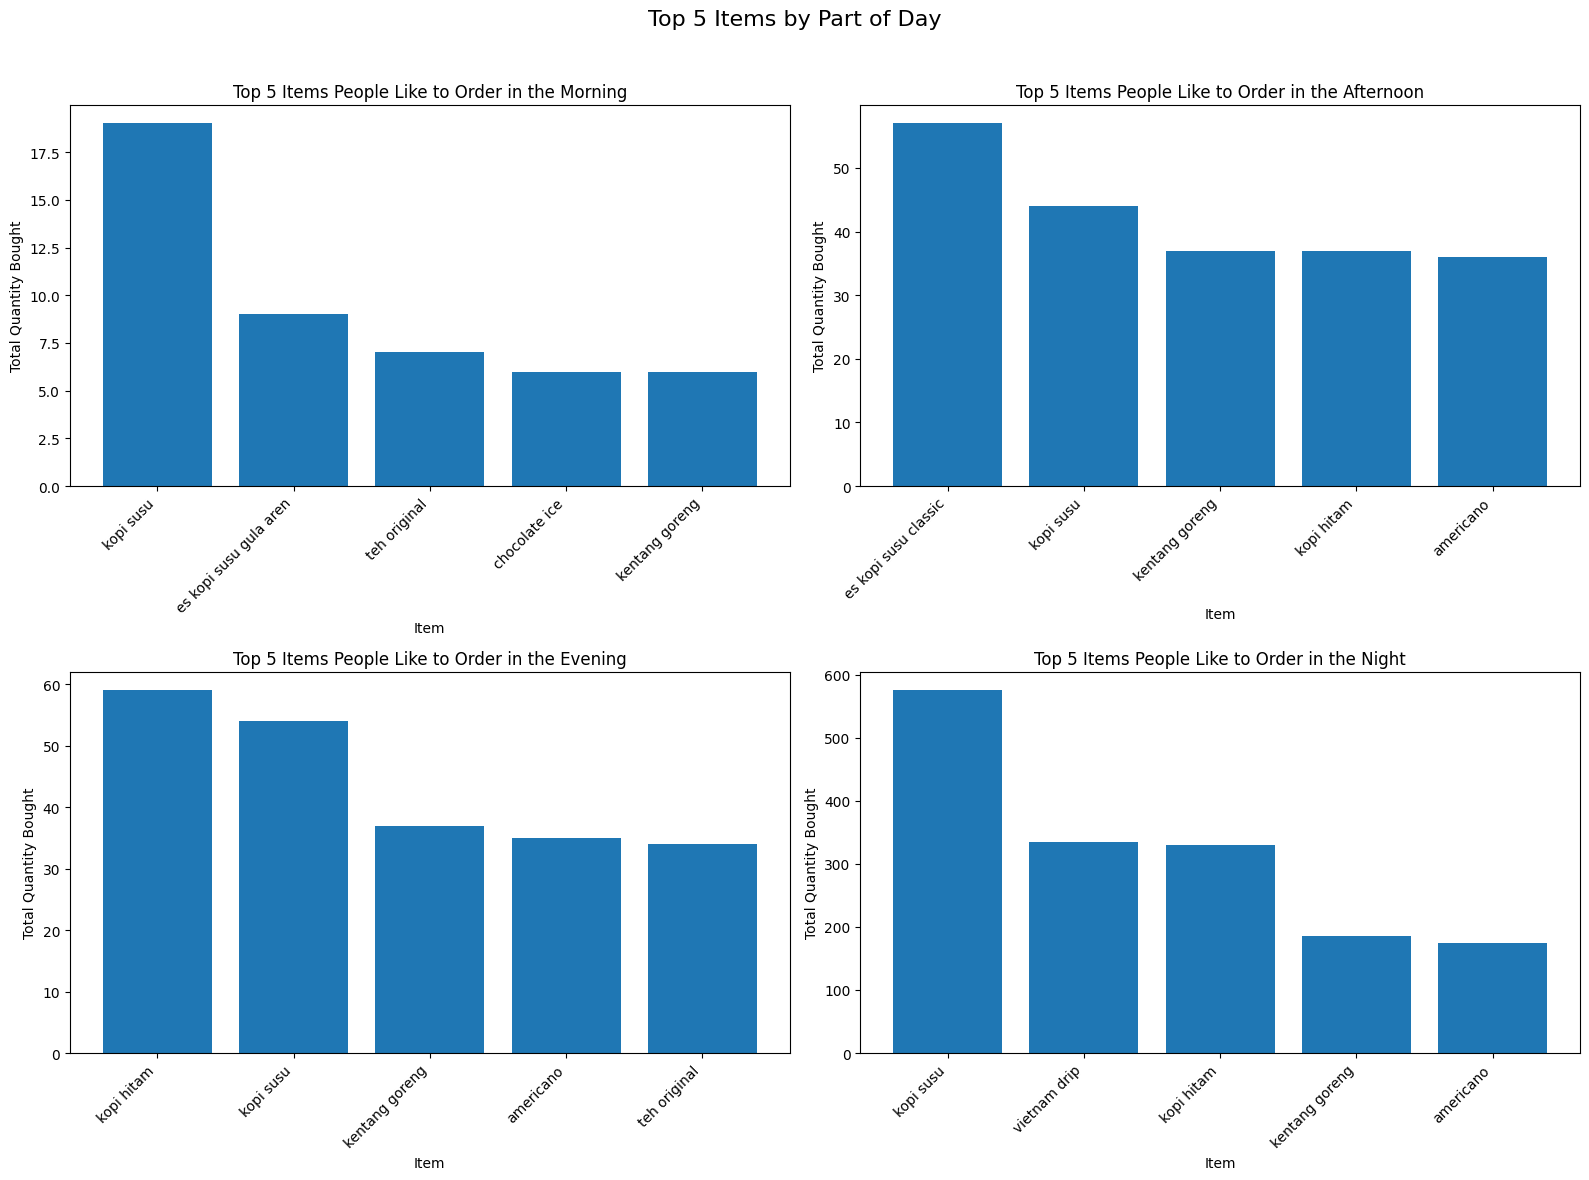

In [14]:
def transform_data_with_date(df):
    new_rows = []
    for index, row in df.iterrows():
        order_no = row['order no']
        date = row['order time']
        items = row['items'].split(',')  # Split items by ','
        item_counts = Counter(items)  # Count occurrences of each item

        for item, quantity in item_counts.items():
            new_rows.append({'order no': order_no, 'item': item, 'quantity': quantity, 'order time': date})


    return pd.DataFrame(new_rows)

def categorize_time(time):
  hour = time.hour
  if 5 <= hour < 11:
    return 'Morning'
  elif 11 <= hour < 15:
    return 'Afternoon'
  elif 15 <= hour < 18:
    return 'Evening'
  else:
    return 'Night'

transformed_df_with_date = transform_data_with_date(df_with_date)

# Convert 'order time' to datetime and categorize into parts of the day
transformed_df_with_date['order time'] = pd.to_datetime(transformed_df_with_date['order time'])
transformed_df_with_date['part_of_day'] = transformed_df_with_date['order time'].apply(categorize_time)

# Define parts of the day
parts_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create subplots for each part of the day
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid
fig.suptitle('Top 5 Items by Part of Day', fontsize=16)

# Flatten axes for proper indexing
axes = axes.flatten()

for i, part_of_day in enumerate(parts_of_day):
    ax = axes[i]  # Get the subplot axis
    filtered_df = transformed_df_with_date[transformed_df_with_date['part_of_day'] == part_of_day]
    item_counts = filtered_df.groupby('item')['quantity'].sum().sort_values(ascending=False)
    top_5_items = item_counts.head(5)

    if not top_5_items.empty:
        ax.bar(top_5_items.index, top_5_items.values)
        ax.set_xlabel("Item")
        ax.set_ylabel("Total Quantity Bought")
        ax.set_title(f"Top 5 Items People Like to Order in the {part_of_day}")
        ax.set_xticks(range(len(top_5_items)))
        ax.set_xticklabels(top_5_items.index, rotation=45, ha='right')  # Rotate x-axis labels for readability
    else:
        ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax.set_title(f"No Data - {part_of_day}")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


# Data Mining

In [46]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

pd.set_option('display.max_rows', None)

# min support 0.1%
frequent_itemsets = apriori(basket_filter, min_support=0.01, use_colnames=True)

frequent_itemsets = frequent_itemsets.sort_values(by=['support'], ascending=False)

#add 'length' column
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))

print(frequent_itemsets)

pd.reset_option('display.max_rows')


     support                                  itemsets  length
18  0.185458                          (kentang goreng)       1
22  0.156046                               (kopi susu)       1
45  0.153595                            (vietnam drip)       1
16  0.145425                          (indomie goreng)       1
20  0.133170                              (kopi hitam)       1
40  0.116013                                   (telur)       1
2   0.093137                               (americano)       1
7   0.088235                           (chocolate ice)       1
10  0.085784                    (es kopi susu classic)       1
58  0.077614                   (telur, indomie goreng)       2
38  0.075980                            (teh original)       1
11  0.074346                  (es kopi susu gula aren)       1
26  0.072712                          (red velvet ice)       1
24  0.072712                              (matcha ice)       1
25  0.065359                               (mix snack) 

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Find association rules needed

In [47]:
association_rules = association_rules(frequent_itemsets, metric="lift", num_itemsets=2).sort_values(by=['lift'], ascending=False)
display(association_rules)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(telur),(indomie rebus),0.116013,0.057190,0.042484,0.366197,6.403219,1.0,0.035849,1.487545,0.954571,0.325000,0.327752,0.554527
3,(indomie rebus),(telur),0.057190,0.116013,0.042484,0.742857,6.403219,1.0,0.035849,3.437727,0.895014,0.325000,0.709110,0.554527
1,(indomie goreng),(telur),0.145425,0.116013,0.077614,0.533708,4.600411,1.0,0.060743,1.895779,0.915810,0.422222,0.472512,0.601361
0,(telur),(indomie goreng),0.116013,0.145425,0.077614,0.669014,4.600411,1.0,0.060743,2.581908,0.885339,0.422222,0.612690,0.601361
26,(matcha ice),(mix snack),0.072712,0.065359,0.013889,0.191011,2.922472,1.0,0.009136,1.155320,0.709407,0.111842,0.134439,0.201756
27,(mix snack),(matcha ice),0.065359,0.072712,0.013889,0.212500,2.922472,1.0,0.009136,1.177508,0.703826,0.111842,0.150749,0.201756
40,(chocolate ice),(sosis nugget),0.088235,0.063725,0.013072,0.148148,2.324786,1.0,0.007449,1.099105,0.625000,0.094118,0.090169,0.176638
41,(sosis nugget),(chocolate ice),0.063725,0.088235,0.013072,0.205128,2.324786,1.0,0.007449,1.147059,0.608639,0.094118,0.128205,0.176638
31,(singkong keju),(kentang goreng),0.046569,0.185458,0.013889,0.298246,1.608161,1.0,0.005252,1.160723,0.396643,0.063670,0.138468,0.186568
30,(kentang goreng),(singkong keju),0.185458,0.046569,0.013889,0.074890,1.608161,1.0,0.005252,1.030614,0.464275,0.063670,0.029705,0.186568


**Add Filter Association rules based on parameter**

Parameter Needed:

*   Lift >= 1
*   Confidence > 25%
*   Support >= 1%

In [17]:
filtered_rules = association_rules[(association_rules['lift'] >= 1) & (association_rules['support'] > 0.01) & (association_rules['confidence'] > 0.25)]
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(telur),(indomie rebus),0.116013,0.057190,0.042484,0.366197,6.403219,1.0,0.035849,1.487545,0.954571,0.325000,0.327752,0.554527
3,(indomie rebus),(telur),0.057190,0.116013,0.042484,0.742857,6.403219,1.0,0.035849,3.437727,0.895014,0.325000,0.709110,0.554527
1,(indomie goreng),(telur),0.145425,0.116013,0.077614,0.533708,4.600411,1.0,0.060743,1.895779,0.915810,0.422222,0.472512,0.601361
0,(telur),(indomie goreng),0.116013,0.145425,0.077614,0.669014,4.600411,1.0,0.060743,2.581908,0.885339,0.422222,0.612690,0.601361
31,(singkong keju),(kentang goreng),0.046569,0.185458,0.013889,0.298246,1.608161,1.0,0.005252,1.160723,0.396643,0.063670,0.138468,0.186568
35,(cappuccino),(kentang goreng),0.044935,0.185458,0.013072,0.290909,1.568602,1.0,0.004738,1.148714,0.379544,0.060150,0.129461,0.180697
53,(kopi ijo susu),(kentang goreng),0.038399,0.185458,0.010621,0.276596,1.491424,1.0,0.003500,1.125985,0.342657,0.049808,0.111889,0.166932
29,(taro ice),(kentang goreng),0.051471,0.185458,0.013889,0.269841,1.455003,1.0,0.004343,1.115569,0.329685,0.062271,0.103597,0.172366
14,(matcha ice),(kentang goreng),0.072712,0.185458,0.019608,0.269663,1.454041,1.0,0.006123,1.115297,0.336747,0.082192,0.103378,0.187695
36,(tempura ikan),(kentang goreng),0.049020,0.185458,0.013072,0.266667,1.437885,1.0,0.003981,1.110740,0.320232,0.059041,0.099699,0.168576


## Export association rules to csv

In [48]:
filtered_rules.to_csv('association_rules.csv', index=False)